In [1]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('sagemaker version:' + sagemaker.__version__)

sagemaker version:2.72.1


In [2]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::026562189436:role/service-role/AmazonSageMaker-ExecutionRole-20201128T144505'

In [3]:
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/emlo-cifar100'

checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)
print(f'checkpointing path : {checkpoint_s3_path}')

checkpointing path : s3://sagemaker-us-west-2-026562189436/checkpoint-c9ae381f


In [4]:
import os
import subprocess 

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    # Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print('instance_type:', instance_type)

instance_type: local


In [5]:
pip install pytorch-lightning --quiet

Note: you may need to restart the kernel to use updated packages.


In [6]:
from cifar100 import CIFAR100DataModule
cifar100_dm = CIFAR100DataModule(batch_size=64)
cifar100_dm.prepare_data()
cifar100_dm.setup()
trainloader = cifar100_dm.train_dataloader()
testloader = cifar100_dm.test_dataloader()

Global seed set to 7


Files already downloaded and verified


In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [8]:
import numpy as np
import torchvision, torch
import matplotlib.pyplot as plt

classes = ("beaver", "dolphin", "otter", "seal", "whale", "aquarium fish", "flatfish", "ray", "shark", "trout",\
           "orchids", "poppies", "roses", "sunflowers", "tulips", "bottles", "bowls", "cans", "cups", "plates", \
           "apples", "mushrooms", "oranges", "pears", "sweet peppers", "clock", "computer keyboard", "lamp", \
           "telephone", "television", "bed", "chair", "couch", "table", "wardrobe", "bee", "beetle", \
           "butterfly", "caterpillar", "cockroach", "bear", "leopard", "lion", "tiger", "wolf", "bridge", \
           "castle",  "house", "road", "skyscraper", "cloud", "forest", "mountain", "plain", "sea", "camel", \
           "cattle", "chimpanzee", "elephant", "kangaroo", "fox", "porcupine", "possum", "raccoon", "skunk", \
           "crab", "lobster", "snail", "spider", "worm", "baby", "boy", "girl", "man", "woman", "crocodile", \
           "dinosaur", "lizard", "snake", "turtle", "hamster", "mouse", "rabbit", "shrew", "squirrel", \
           "maple", "oak", "palm", "pine", "willow", "bicycle", "bus", "motorcycle", "pickup truck", \
           "train", "lawn-mower", "rocket", "streetcar", "tank", "tractor" \
           )

In [9]:
len(classes)

100

In [10]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


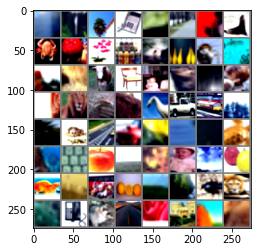

In [11]:
# show images
imshow(torchvision.utils.make_grid(images))

In [12]:
inputs = sagemaker_session.upload_data(path = ".", bucket = bucket, key_prefix="data/cifar100_latest")

In [13]:
use_spot_instances = True
max_run = 800
max_wait = 1200 if use_spot_instances else None

In [14]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'batch_size': 64, 'checkpoint-path':checkpoint_s3_path}

cifar100_estimator = PyTorch(
    entry_point = "cifar100.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    hyperparameters=hyperparameters,
    instance_count=2,
    instance_type="ml.p3.8xlarge",
    base_job_name = 'cifar100-pytorch-lighning-Jan27-spot',
    checkpoints_s3_uri = checkpoint_s3_path,
    debugger_hook_config = False,
    use_spot_instances = use_spot_instances,
    max_run = max_run,
    max_wait = max_wait
)

In [15]:
cifar100_estimator.fit(inputs)

2022-01-27 11:49:20 Starting - Starting the training job...
2022-01-27 11:49:43 Starting - Launching requested ML instancesProfilerReport-1643284160: InProgress
.........
2022-01-27 11:51:04 Starting - Preparing the instances for training...............
2022-01-27 11:53:44 Downloading - Downloading input data
2022-01-27 11:53:44 Training - Downloading the training image.......bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-27 11:54:55,199 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-27 11:54:55,242 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-27 11:54:58,263 sagemaker_pytorch_container.training INFO     Invoking user training script.
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-27 11:54:55,291 sagemaker-training-toolkit INFO     Imported

In [16]:
from sagemaker.pytorch import PyTorchModel

predictor = cifar100_estimator.deploy(initial_instance_count=1, instance_type="ml.c4.8xlarge")

-------!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])
Ground Truth : orchids orchids beaver whale
Predicted :  cups bowls beaver roses


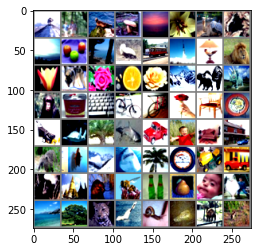

In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.size())

# print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth :', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted : ', ' '.join('%4s' % classes[predicted[j]] for j in range(4)))

In [18]:
predictor.delete_endpoint()